In [5]:
#import scltnn
import scanpy as sc
import scvelo as scv
import anndata
import numpy as np

In [6]:
import omicverse as ov
ov.utils.ov_plot_set()

In [2]:
from velovi import preprocess_data, VELOVI

Global seed set to 0


In [7]:
adata=sc.read_h5ad('../LTNN/data/Pancreas-velocyto.h5ad')
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'phase', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [ ]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # cell amount will influence the setting of n_neighbors

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [11]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [01:23<00:00,  6.00it/s, loss=-2.64e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:23<00:00,  5.99it/s, loss=-2.64e+03, v_num=1]


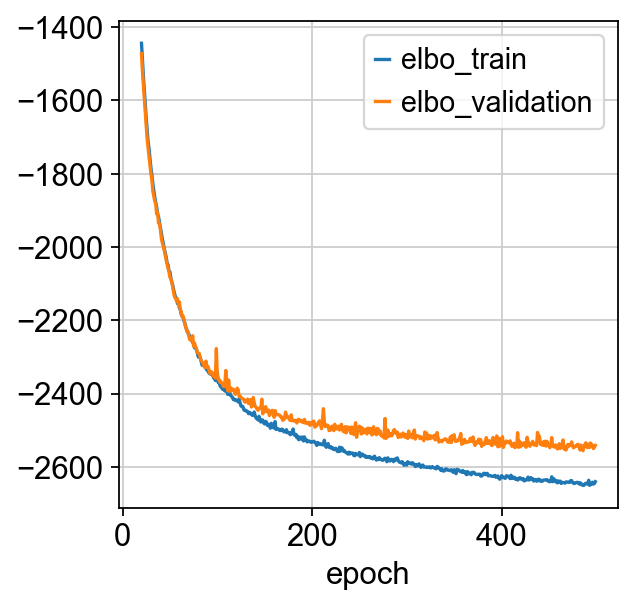

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

In [13]:
import torch
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [14]:
adata.obs['latent_time_raw']=adata.obs['latent_time'].copy()

In [23]:
likeli = vae.get_gene_likelihood(n_samples=25,)

In [37]:
adata.obs['latent_time_velovi']=vae.get_latent_time(n_samples=25,return_numpy=False).mean(axis=1).loc[adata.obs.index].values

In [39]:
vae.get_elbo()

tensor(2656.2156, device='cuda:0')

In [27]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/12 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


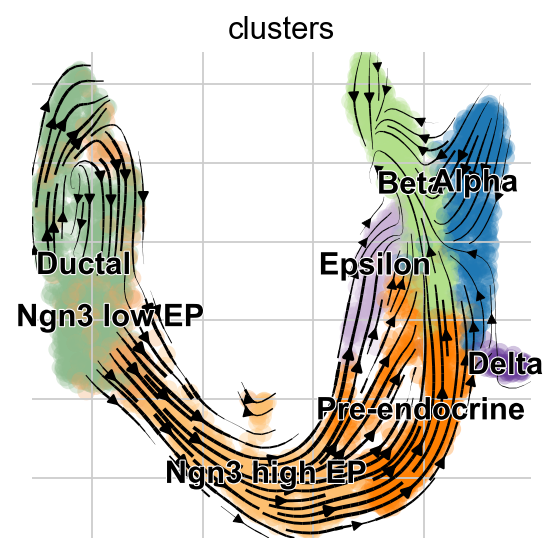

In [30]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [44]:
del adata.obs['root_cells']
scv.tl.latent_time(adata, min_likelihood=None)
#scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/omicverse/utils/_scatterplot.py:483: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(cax, orientation="vertical", cax=cax1)


[<AxesSubplot: title={'center': 'latent_time_raw'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <AxesSubplot: title={'center': 'latent_time'}, xlabel='X_umap1', ylabel='X_umap2'>]

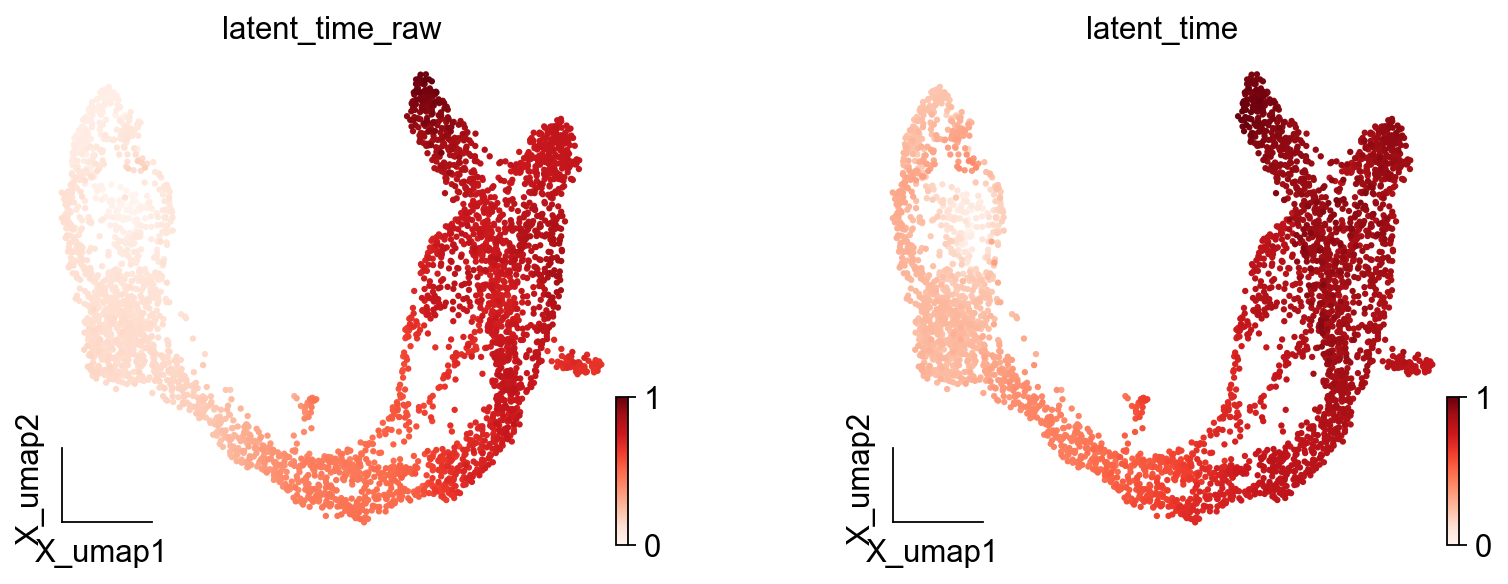

In [45]:
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(adata,basis='X_umap', color=['latent_time_raw','latent_time'], 
               cmap='Reds',legend_loc='right margin',frameon='small',
                   ncols=2,wspace=0.4,show=False,
                   #ax=ax
                  )

In [46]:
import Epiverse as ev
ev.utils.lsi(adata, n_components=20, n_iter=15)

In [47]:
ltnn_obj=ov.single.scLTNN(adata,basis='X_lsi',input_dim=20,cpu='cuda:0')

In [48]:
ltnn_obj.ANNmodel_init(pseudotime='latent_time',batch_size=20,)
ltnn_obj.ANNmodel_train(n_epochs=200)

Pre-ANN model: 100%|██████████| 200/200 [00:30<00:00,  6.46it/s, val loss, val mae=0.00070, 0.00070]


In [49]:
ltnn_obj.ANNmodel_save('model/model_20.h5')